# Spatial weights

In [2]:
import contextily as ctx
import geopandas as gpd 
import rioxarray
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from pysal.lib import cg as geometry
from pysal.lib import weights

# Contiguity weights

In [3]:
l = np.arange(3)
xs, ys = np.meshgrid(l, l)

In [11]:
polys = [Polygon([(x, y), (x+1, y), (x+1, y+1), (x, y+1)]) 
        for x, y in zip(xs.flatten(), ys.flatten())]

In [15]:
polys = gpd.GeoSeries(polys)
gdf = gpd.GeoDataFrame(
    {
        "geometry": polys, 
        "id": ["P-%s" % str(i).zfill(2) for i in range(len(polys))]
    }
)

In [16]:
gdf

,geometry,id
0,"POLYGON ((0 0, 1 0, 1 1, 0 1, 0 0))",P-00
1,"POLYGON ((1 0, 2 0, 2 1, 1 1, 1 0))",P-01
2,"POLYGON ((2 0, 3 0, 3 1, 2 1, 2 0))",P-02
3,"POLYGON ((0 1, 1 1, 1 2, 0 2, 0 1))",P-03
4,"POLYGON ((1 1, 2 1, 2 2, 1 2, 1 1))",P-04
5,"POLYGON ((2 1, 3 1, 3 2, 2 2, 2 1))",P-05
6,"POLYGON ((0 2, 1 2, 1 3, 0 3, 0 2))",P-06
7,"POLYGON ((1 2, 2 2, 2 3, 1 3, 1 2))",P-07
8,"POLYGON ((2 2, 3 2, 3 3, 2 3, 2 2))",P-08


In [39]:
def neighborPlot(gdf, polys):
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(aspect='equal'))
    gdf.plot(ax=ax, fc='w', ec='k')
    for x, y, t in zip(
        [p.centroid.x - 0.25 for p in polys], 
        [p.centroid.y - 0.25 for p in polys], 
        [i for i in gdf.id]
    ): 
        plt.text(x, y, t, 
                va="center", ha="center")
    ax.set_axis_off()
    return fig, ax

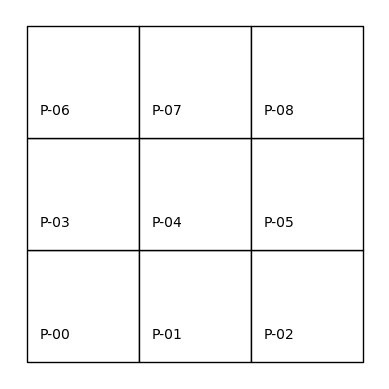

In [40]:
fig, ax = neighborPlot(gdf, polys);

>Build a rook continuity matrix

In [20]:
wr = weights.contiguity.Rook.from_dataframe(gdf, use_index=False)
wr

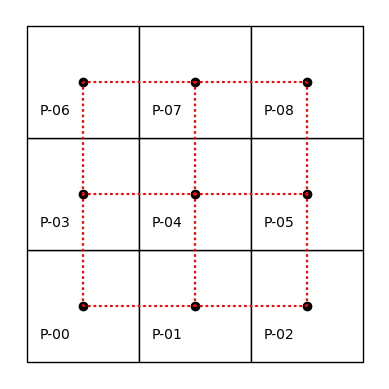

In [41]:
fig, ax = neighborPlot(gdf, polys)
wr.plot(gdf, edge_kws=dict(color='r', ls=':'), ax=ax);

In [24]:
wr.neighbors

{0: [1, 3],
 1: [0, 2, 4],
 2: [1, 5],
 3: [0, 4, 6],
 4: [1, 3, 5, 7],
 5: [8, 2, 4],
 6: [3, 7],
 7: [8, 4, 6],
 8: [5, 7]}

In [25]:
pd.DataFrame(*wr.full()).astype(int)

,0,1,2,3,4,5,6,7,8
0,0,1,0,1,0,0,0,0,0
1,1,0,1,0,1,0,0,0,0
2,0,1,0,0,0,1,0,0,0
3,1,0,0,0,1,0,1,0,0
4,0,1,0,1,0,1,0,1,0
5,0,0,1,0,1,0,0,0,1
6,0,0,0,1,0,0,0,1,0
7,0,0,0,0,1,0,1,0,1
8,0,0,0,0,0,1,0,1,0


In [26]:
wr.full()

(array([[0., 1., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 1., 0., 1., 0., 0.],
        [0., 1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 1., 0., 1., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0., 1., 0.]]),
 [0, 1, 2, 3, 4, 5, 6, 7, 8])

In [27]:
wr.nonzero

24

>Build a queen contiguity matrix

In [29]:
wq = weights.contiguity.Queen.from_dataframe(gdf, use_index=False)
wq.neighbors

{0: [1, 3, 4],
 1: [0, 2, 3, 4, 5],
 2: [1, 4, 5],
 3: [0, 1, 4, 6, 7],
 4: [0, 1, 2, 3, 5, 6, 7, 8],
 5: [1, 2, 4, 7, 8],
 6: [3, 4, 7],
 7: [3, 4, 5, 6, 8],
 8: [4, 5, 7]}

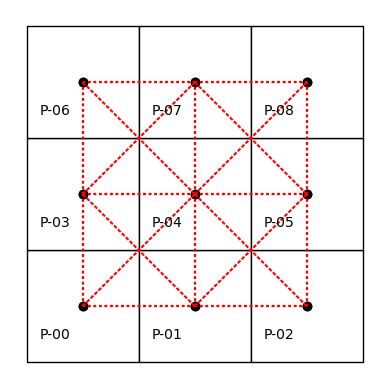

In [34]:
fig, ax = neighborPlot(gdf, polys)
wq.plot(gdf, edge_kws=dict(color='r', ls=':'), ax=ax);

In [42]:
wq.weights

{0: [1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0]}

The number of neighbors per occurrence

In [43]:
wq.cardinalities

{0: 3, 1: 5, 2: 3, 3: 5, 4: 8, 5: 5, 6: 3, 7: 5, 8: 3}

In [44]:
wq.histogram

[(3, 4), (4, 0), (5, 4), (6, 0), (7, 0), (8, 1)]

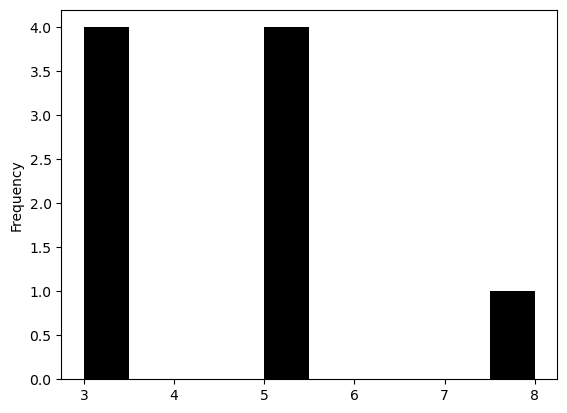

In [46]:
pd.Series(wq.cardinalities).plot.hist(color='k');

>Total number of connections and density

In [48]:
wq.s0, wq.pct_nonzero

(40.0, 49.382716049382715)

## Weights from real-world geo tables

In [52]:
san_diego_tracts = gpd.read_file("../data/sandiego_tracts.gpkg")
w_queen = weights.contiguity.Queen.from_dataframe(san_diego_tracts, use_index=False)

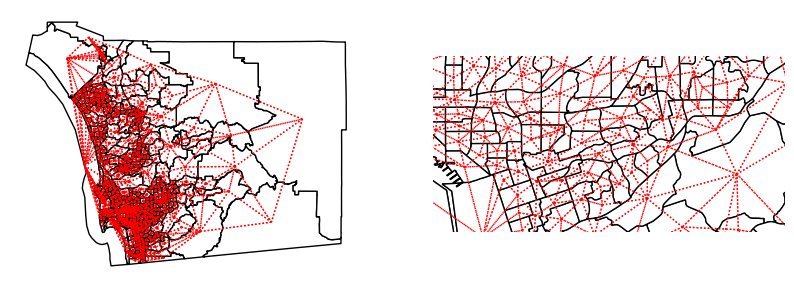

In [59]:
# Plot tract geography
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
for ax in (ax1, ax2):
    san_diego_tracts.plot(
        edgecolor="k", facecolor="w", ax=ax
    )
    # Plot graph connections
    w_queen.plot(
        san_diego_tracts,
        ax=ax,
        edge_kws=dict(color="r", linestyle=":", linewidth=1),
        node_kws=dict(marker=""),
    )
    # Remove the axis
    ax.set_axis_off()
ax2.axis([-13040000, -13020000, 3850000, 3860000]);

In [60]:
w_queen.n, w_queen.pct_nonzero

(628, 1.018296888311899)

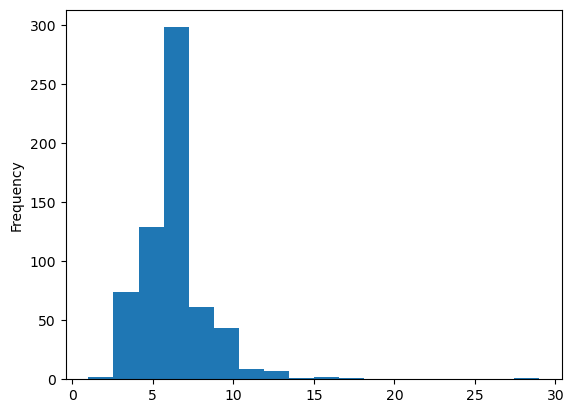

In [61]:
s = pd.Series(w_queen.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

0.8722463385938578


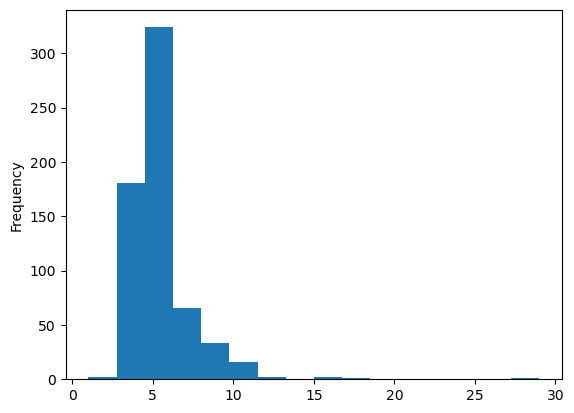

In [63]:
w_rook = weights.contiguity.Rook.from_dataframe(san_diego_tracts, use_index=False)
print(w_rook.pct_nonzero)
s = pd.Series(w_rook.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

# Spatial weights from surfaces

In [64]:
sao_paulo = rioxarray.open_rasterio("../data/ghsl_sao_paulo.tif")

In [ ]:
w_sao_paulo = weights.contiguity.Queen.from_xarray(sao_paulo)
w_sao_paulo

# Distance based weights

## K-nearest neighbor

In [67]:
wk4 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=4)

In [68]:
wk4.islands

[]

In [69]:
wk4.histogram

[(4, 628)]

>Kernel weights - decay with distance

>Fixed bandwidth

In [70]:
w_kernel = weights.distance.Kernel.from_dataframe(gdf)

In [71]:
w_kernel.function

'triangular'

In [72]:
w_kernel.bandwidth[0:5]

array([[1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001],
       [1.0000001]])

In [73]:
w_kernel.bandwidth.shape

(9, 1)

>Adaptive bandwidths

In [74]:
sub_30 = san_diego_tracts.query("sub_30 == True")

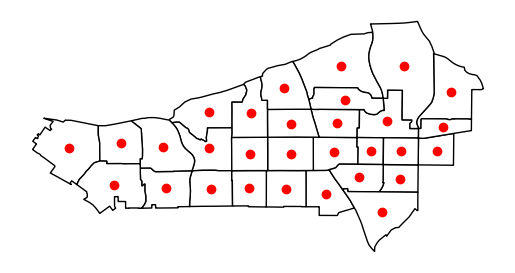

In [75]:
ax = sub_30.plot(fc='w', ec='k')
sub_30.head(30).centroid.plot(color='r', ax=ax)
ax.set_axis_off();

In [76]:
w_adaptive = weights.distance.Kernel.from_dataframe(sub_30, 
                                                   fixed=False, 
                                                   k=15)
w_adaptive.bandwidth[:5]

array([[7065.74020822],
       [3577.22591841],
       [2989.74807871],
       [2891.46196945],
       [3965.08354232]])

>Create a full matrix

In [77]:
full_matrix, ids = w_adaptive.full() 

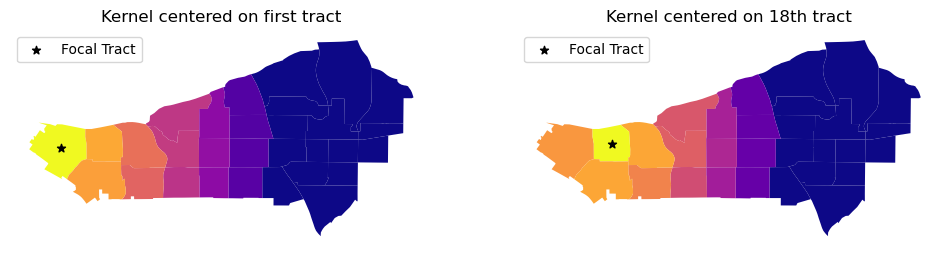

In [79]:
f, (ax1, ax2) = plt.subplots(1, 2, 
                             figsize=(12,6), 
                            subplot_kw=dict(aspect='equal'))
sub_30.assign(weight_0=full_matrix[0]).plot(
    "weight_0", cmap='plasma', ax=ax1
)
sub_30.assign(weight_18=full_matrix[17]).plot(
    "weight_18", cmap="plasma", ax=ax2
)
sub_30.iloc[[0], :].centroid.plot(
    ax=ax1, marker="*", color="k", label="Focal Tract"
)
sub_30.iloc[[17], :].centroid.plot(
    ax=ax2, marker="*", color="k", label="Focal Tract"
)
ax1.set_title('Kernel centered on first tract')
ax2.set_title("Kernel centered on 18th tract")
[ax.set_axis_off() for ax in (ax1, ax2)]
[ax.legend(loc="upper left") for ax in (ax1, ax2)];

In [80]:
w_kernel.pct_nonzero

40.74074074074074

# Distance bands and hybrid weights

>Set threshold of 1.5

In [83]:
w_bdb = weights.distance.DistanceBand.from_dataframe(gdf, 1.5, binary=False)

>Hybrid

In [84]:
w_hy = weights.distance.DistanceBand.from_dataframe(
    gdf, 1.5, binary=False
)

/nix/store/sasr3ws6sy2ha278si0s7m4hwgrcm3r4-python3-3.12.7-env/lib/python3.12/site-packages/scipy/sparse/_data.py:134: RuntimeWarning: divide by zero encountered in reciprocal
  return self._with_data(data ** n)


In [85]:
wq.weights[4], w_hy.weights[4]

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 [0.7071067811865475,
  1.0,
  0.7071067811865475,
  1.0,
  1.0,
  0.7071067811865475,
  1.0,
  0.7071067811865475])

# Great circle distances

>Without considering curavature

In [90]:
knn4_bad = weights.distance.KNN.from_shapefile(
    "../data/texas/texas.shp", k=4,
)

/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/io/iohandlers/pyShpIO.py:247: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  shp = self.type(vertices)
/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/cg/shapes.py:1408: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._part_rings = [Ring(vertices)]
/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/cg/shapes.py:1279: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._centroid = Point((cx, cy))
/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/io/iohandlers/pyShpIO.py:232: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in

In [91]:
radius = geometry.sphere.RADIUS_EARTH_MILES
radius

3958.755865744055

In [92]:
knn4 = weights.distance.KNN.from_shapefile(
    "../data/texas/texas.shp", k=4, radius=radius
)

/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/io/iohandlers/pyShpIO.py:247: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  shp = self.type(vertices)
/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/cg/shapes.py:1408: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._part_rings = [Ring(vertices)]
/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/cg/shapes.py:1279: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  self._centroid = Point((cx, cy))
/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/io/iohandlers/pyShpIO.py:232: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in

In [95]:
print(knn4[0])
print(knn4_bad[0])

{6: 1.0, 4: 1.0, 5: 1.0, 3: 1.0}
{6: 1.0, 4: 1.0, 5: 1.0, 13: 1.0}


# Block weights

In [96]:
san_diego_tracts[["GEOID", "state", "county", "tract"]].head()

,GEOID,state,county,tract
0,06073018300,06,073,018300
1,06073018601,06,073,018601
2,06073017601,06,073,017601
3,06073019301,06,073,019301
4,06073018700,06,073,018700


>Build a block weights object

In [97]:
w_bl = weights.util.block_weights(
    san_diego_tracts["county"].values, 
    ids=san_diego_tracts['GEOID'].values
)

In [98]:
"06073000201" in w_bl["06073000100"]

True

# Set operations on weights

>Disconnected observations - add connection to nearest neighbor

In [99]:
disconnected_tract = san_diego_tracts.iloc[[103]]

In [100]:
w_queen[103]

{160: 1.0, 480: 1.0, 98: 1.0, 324: 1.0, 102: 1.0, 107: 1.0, 173: 1.0}

>Assume that there are no connections. Determine the nearest neighbor

In [101]:
wk1 = weights.distance.KNN.from_dataframe(san_diego_tracts, k=1, use_index=False)

/home/biscotty/Learning/GeoDSPython/_build/pip_packages/lib/python3.12/site-packages/libpysal/weights/distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 153 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


In [102]:
wk1.histogram

[(1, 628)]

In [103]:
wk1.neighbors[103]

[102]

In [104]:
neighbors = w_rook.neighbors.copy()
neighbors[103].append(102)
neighbors[102].append(103)
w_new = weights.W(neighbors)
w_new[103]

{480: 1.0, 160: 1.0, 324: 1.0, 102: 1.0, 107: 1.0, 173: 1.0}

>Union of matrices

easy way to deal with islands

In [105]:
w_fixed_sets = weights.set_operations.w_union(w_rook, wk1)

# Visualizing weight set operations

In [106]:
mx = gpd.read_file("../data/mexico/mexicojoin.shp")

In [110]:
mx.columns

Index(['POLY_ID', 'AREA', 'CODE', 'NAME', 'PERIMETER', 'ACRES', 'HECTARES',
       'PCGDP1940', 'PCGDP1950', 'PCGDP1960', 'PCGDP1970', 'PCGDP1980',
       'PCGDP1990', 'PCGDP2000', 'HANSON03', 'HANSON98', 'ESQUIVEL99', 'INEGI',
       'INEGI2', 'MAXP', 'GR4000', 'GR5000', 'GR6000', 'GR7000', 'GR8000',
       'GR9000', 'LPCGDP40', 'LPCGDP50', 'LPCGDP60', 'LPCGDP70', 'LPCGDP80',
       'LPCGDP90', 'LPCGDP00', 'TEST', 'geometry'],
      dtype='object')

>Queen continuity, Knn4, block weights, block/Queen hybrid

In [111]:
mx_queen = weights.contiguity.Queen.from_dataframe(mx, use_index=False)

In [112]:
mx_knn4 = weights.KNN.from_dataframe(mx, k=4)

>INEGI2 is the federal region level

In [116]:
mx_bw = weights.util.block_weights(mx["INEGI2"].values)

In [117]:
mx_union = weights.set_operations.w_union(mx_bw, mx_queen)

In [127]:
def nbr_plot(df, wf, ax, title): 
    wf.plot(
        df, 
        edge_kws=dict(lw=1, color='orangered'), 
        node_kws=dict(marker="*"), 
        ax=ax
    )
    ax.set_axis_off()
    ax.set_title(title)
    return ax

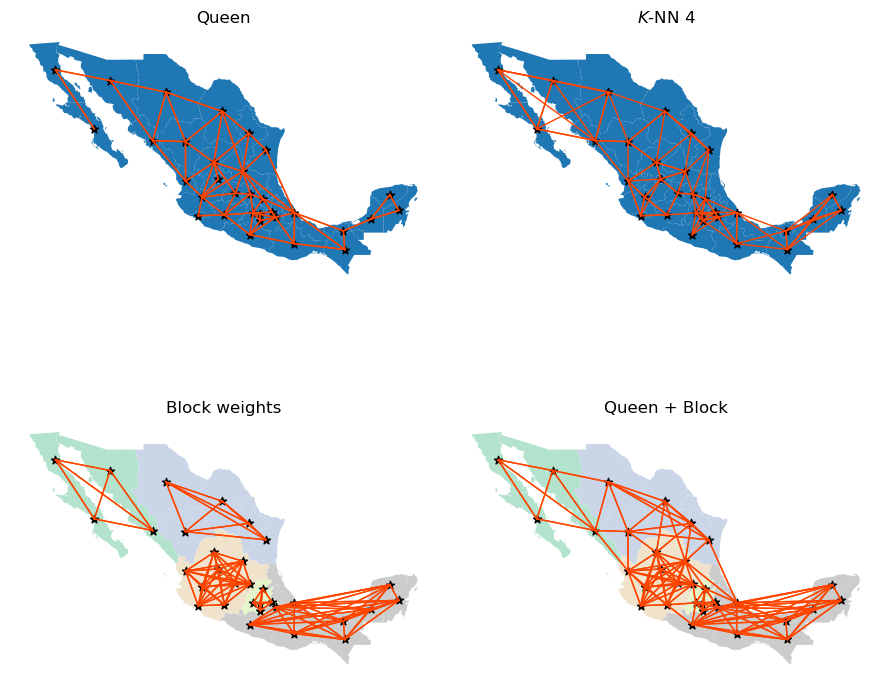

In [128]:
# Set up figure and axis
f, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(9, 9))

# Contiguity
mx.plot(ax=ax11)
nbr_plot(mx, mx_queen, ax11, "Queen")

# KNN
mx.plot(ax=ax12)
nbr_plot(mx, mx_knn4, ax12, "$K$-NN 4")

# Block
mx.plot(column="INEGI2", categorical=True, cmap="Pastel2", ax=ax21)
nbr_plot(mx, mx_bw, ax21, "Block weights")

# Union
mx.plot(column="INEGI2", categorical=True, cmap="Pastel2", ax=ax22)
nbr_plot(mx, mx_union, ax22, "Queen + Block")

f.tight_layout()
plt.show()

In [132]:
[print("Density: ", x.pct_nonzero) for x in (mx_queen, mx_bw, mx_knn4, mx_union)]

Density:  13.4765625
Density:  19.140625
Density:  12.5
Density:  24.0234375


[None, None, None, None]